# Case Study: SMS Spam Classification
Created by NLP Squad - Orbit Future Academy<br>
Senin, 28 Maret 2022


![title](https://undangmi.com/wp-content/uploads/2022/03/Screen-Shot-2022-03-26-at-23.14.46.png)

Langkah-langkah yang diperlukan:
1. Akuisisi data
2. Text Preprocessing
  1. Case folding
  2. Word Normalization
  3. Stopword removal
  4. Stemming
3. Feature Engineering
  1. Feature Extraction - Bag of Words
  2. Feature Extraction - TFIDF
  3. Feature Selection - Chi Square
4. Modelling (Machine Learning)# coming soon
5. Model Evaluation # coming soon
6. Deployment # coming soon

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 5.2 MB/s 


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Untuk mempermudah kita dalam menyimpan objek agar dapat kita gunakan untuk pemodelan maupun deployment
import pickle

In [66]:
# Buat folder pada Google Drive untuk eksperimen
# Sambungkan Google Colab dengan Google Drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [67]:
# Pindahkan direktori ke folder eksperimen
%cd /content/gdrive/MyDrive/Colab Notebooks/Group 2

/content/gdrive/MyDrive/Colab Notebooks/Group 2


In [68]:
!ls

# Data Acquisition
Penjelasan label:
- 0 --> SMS Normal
- 1 --> SMS Fraud atau penipuan
- 2 --> SMS Promo

In [71]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-03-28 09:07:36--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.02s   

2022-03-28 09:07:36 (6.40 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [5]:
data = pd.read_csv('dataset_sms_spam_v1.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [8]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



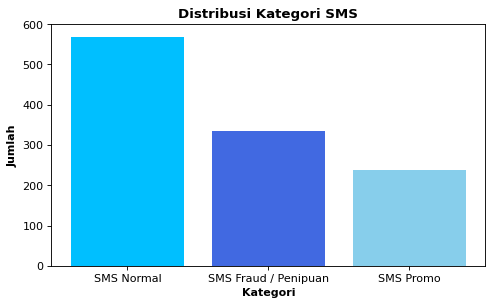

In [9]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# Text Preprocessing

## Case Folding

In [14]:
import re

# Buat fungsi untuk melakukan case folding
def casefolding(text):
  text = text.lower()                                 # Ubah jadi lowercase
  text = re.sub(r'https?://\S+|www\.\S+', '', text)   # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)             # Menghapus karakter angka
  text = re.sub(r'[^\w\s]', '', text)                 # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [20]:
raw_text = data['teks'].iloc[5]
case_folding = casefolding(raw_text)

print('Raw text\t: ', raw_text)
print('Case folding\t: ', case_folding)

Raw text	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


## Word Normalization

In [21]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-03-28 07:09:42--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.01s   

2022-03-28 07:09:42 (6.10 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [27]:
key_norm = pd.read_csv('key_norm.csv')

# Buat fungsi untuk melakukan word normalization
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [30]:
raw_text = data['teks'].iloc[5]
case_folding = casefolding(raw_text)
word_normalization = text_normalize(case_folding)

print('Raw text\t: ', raw_text)
print('Case folding\t: ', case_folding)
print('Word normalization\t: ', word_normalization)

Raw text	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Word Normalization	:  hari lagi ekstra pulsa rb dengan beli paket internet bulanan di mytelkomsel untuk pembelian pertama sjk augsept cek detail promo di tselmemytsel


## Filtering (Stopwords Removal)

In [32]:
from nltk.corpus import stopwords

stopwords_id = stopwords.words('indonesian')

In [33]:
len(stopwords_id)

758

In [36]:
# Lihat daftar stopwords Indonesia yang disediakan NLTK
stopwords_id

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [38]:
# Buat fungsi untuk langkah stopwords removal

def remove_stopwords(text):
  clean_word = []
  all_text = text.split()
  for word in all_text:
    if word not in stopwords_id:
      clean_word.append(word)
  return ' '.join(clean_word)

In [39]:
raw_text = data['teks'].iloc[5]
case_folding = casefolding(raw_text)
word_normalization = text_normalize(case_folding)
stopwords_removal = remove_stopwords(word_normalization)

print('Raw text\t: ', raw_text)
print('Case folding\t: ', case_folding)
print('Word normalization\t: ', word_normalization)
print('Stopwords removal\t: ', stopwords_removal)

Raw text	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Word normalization	:  hari lagi ekstra pulsa rb dengan beli paket internet bulanan di mytelkomsel untuk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopwords removal	:  ekstra pulsa rb beli paket internet bulanan mytelkomsel pembelian sjk augsept cek detail promo tselmemytsel


## Stemming

In [40]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming Bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [41]:
raw_text = data['teks'].iloc[5]
case_folding = casefolding(raw_text)
word_normalization = text_normalize(case_folding)
stopwords_removal = remove_stopwords(word_normalization)
text_stemming = stemming(stopwords_removal)

print('Raw text\t: ', raw_text)
print('Case folding\t: ', case_folding)
print('Word normalization\t: ', word_normalization)
print('Stopwords removal\t: ', stopwords_removal)
print('Stemming\t: ', text_stemming)

Raw text	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Word normalization	:  hari lagi ekstra pulsa rb dengan beli paket internet bulanan di mytelkomsel untuk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopwords removal	:  ekstra pulsa rb beli paket internet bulanan mytelkomsel pembelian sjk augsept cek detail promo tselmemytsel
Stemming	:  ekstra pulsa rb beli paket internet bulan mytelkomsel beli sjk augsept cek detail promo tselmemytsel


## Text Preprocessing Pipeline


In [49]:
# Buat fungsi untuk menggabungkan seluruh langkah pada text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stopwords(text)
  text = stemming(text)
  return text

In [50]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika melakukan text preprocessing

CPU times: user 6min 15s, sys: 943 ms, total: 6min 16s
Wall time: 6min 19s


In [52]:
data.head()

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash gb my telkomsel app ext...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,gb rupiah ribu spesial pilih aktif promo sd no...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,gb rupiah ribu spesial pilih aktif buru skb


In [69]:
# Simpan hasil data yang telah melalui proses text preprocessing
data.to_csv('clean_data.csv')

# Feature Engineering

In [54]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [55]:
X

0       promo beli paket flash gb my telkomsel app ext...
1       gb rupiah ribu spesial pilih aktif promo sd no...
2       pulang hormat sisa kuota flash kb download myt...
3       pulang hormat sisa kuota flash kb download myt...
4             gb rupiah ribu spesial pilih aktif buru skb
                              ...                        
1138                           yooo oke umumin grup kelas
1139                     nulis kerudung kirain warna jins
1140                                        mbak kirim ya
1141        nama beaok bwrangkat pagimau cas atay tranfer
1142                                       nomor bri nama
Name: clean_teks, Length: 1143, dtype: object

In [56]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1138    0
1139    0
1140    0
1141    0
1142    0
Name: label, Length: 1143, dtype: int64

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi bentuk vektor menggunakan metode BoW

In [58]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''

from sklearn.feature_extraction.text import CountVectorizer

# Bag of Words menggunakan unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [60]:
# Melihat jumlah token / fitur yang dihasilkan Bag of Words
len(bow.get_feature_names_out())

3256

In [61]:
# Melihat fitur-fitur apa saja yang ada dalam korpus
bow.get_feature_names_out()

array(['aa', 'aamiiiin', 'aamiin', ..., 'zjt', 'zona', 'ztkm'],
      dtype=object)

In [62]:
# Melihat matriks jumlah token
# Hasil ini, siap dimasukkan (di fit kan) dalam proses modelling (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [64]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Simpan objek dari hasil bag of words
with open('hasil_bow.pickle', 'wb') as ouput:
  pickle.dump(X_bow, ouput)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi bentuk vektor menggunakan metode TF-IDF

In [72]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

X_tf_idf = tf_idf.transform(X)

In [73]:
# Melihat jumlah token / fitur yang dihasilkan TF-IDF
len(tf_idf.get_feature_names_out())

3256

In [74]:
# Melihat fitur-fitur apa saja yang ada dalam korpus
tf_idf.get_feature_names_out()

array(['aa', 'aamiiiin', 'aamiin', ..., 'zjt', 'zona', 'ztkm'],
      dtype=object)

In [75]:
# Melihat matriks token menggunakan TF-IDF, lihat perbandingannya dengan metode BoW
# Sama halnya dengan BoW, data ini siap dimasukkan ke proses modelling

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Simpan objek dari hasil TF-IDF
with open('hasil_tf_idf.pickle', 'wb') as ouput:
  pickle.dump(X_tf_idf, ouput)

## Feature Selection

In [78]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [79]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# K features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 3256
Reduced feature number: 1000


In [80]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.835608
1,0.419698
2,1.558607
3,0.716455
4,0.800674
...,...
3251,1.180239
3252,0.503162
3253,0.716455
3254,2.917381


In [81]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.835608,aa
1,0.419698,aamiiiin
2,1.558607,aamiin
3,0.716455,ab
4,0.800674,abadi
...,...,...
3251,1.180239,zalora
3252,0.503162,zarkasi
3253,0.716455,zjt
3254,2.917381,zona


In [82]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2089,47.458531,paket
942,47.106233,gb
1031,46.312452,hadiah
1550,44.568678,kuota
2179,39.429089,pin
...,...,...
1521,0.044910,kopi
307,0.044468,bca
1695,0.031579,maksimal
531,0.013294,cepat


In [83]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [84]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []
for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature
selected_feature

['aamiin',
 'agam',
 'agen',
 'ags',
 'agst',
 'agt',
 'agtskinfodlj',
 'agun',
 'agustuskunjungi',
 'ajak',
 'akses',
 'aktif',
 'aktivasi',
 'alam',
 'alamsyah',
 'aliando',
 'all',
 'aman',
 'amanda',
 'an',
 'anda',
 'andabch',
 'andika',
 'andromax',
 'angga',
 'angpaopoinsenyum',
 'angsur',
 'anrasto',
 'ap',
 'apa',
 'aplikasi',
 'app',
 'apps',
 'appsinapps',
 'argo',
 'armada',
 'artha',
 'artisartis',
 'arya',
 'as',
 'asa',
 'asli',
 'ass',
 'assalamualaikum',
 'at',
 'atas',
 'ato',
 'aug',
 'augsept',
 'avanza',
 'axiata',
 'axis',
 'axisnet',
 'ayah',
 'ayam',
 'ayo',
 'bagi',
 'baik',
 'bakmi',
 'balas',
 'ball',
 'bandung',
 'bandungmulai',
 'bang',
 'banget',
 'bank',
 'banting',
 'banyak',
 'bapa',
 'bareng',
 'barokahmp',
 'baru',
 'baruqskrng',
 'baskin',
 'batas',
 'batin',
 'bawa',
 'bayar',
 'bb',
 'bbm',
 'bch',
 'bebek',
 'beda',
 'belanja',
 'beli',
 'beliau',
 'belikan',
 'bentar',
 'berangkat',
 'beres',
 'berkat',
 'berlakupromo',
 'berrybenka',
 'besok',
 

In [85]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agt,agtskinfodlj,agun,agustuskunjungi,ajak,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
with open('best_feature_chi2.pickle', 'wb') as output:
  pickle.dump(X_kbest_features, output)

# Modelling (Machine Learning)

In [ ]:
# Coming Soon

# Model Evaluation

In [ ]:
# Coming Soon

# Deployment

In [87]:
# Coming Soon

# WordCloud

In [88]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [89]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-03-28 09:27:02--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0.005s  

2022-03-28 09:27:02 (6.35 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [90]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

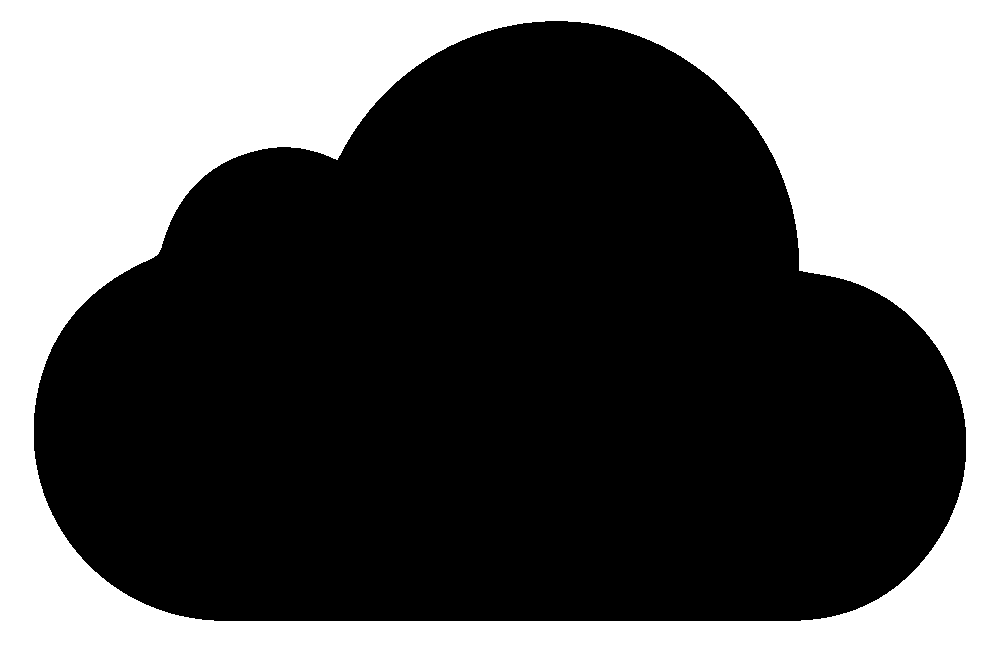

In [91]:
# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

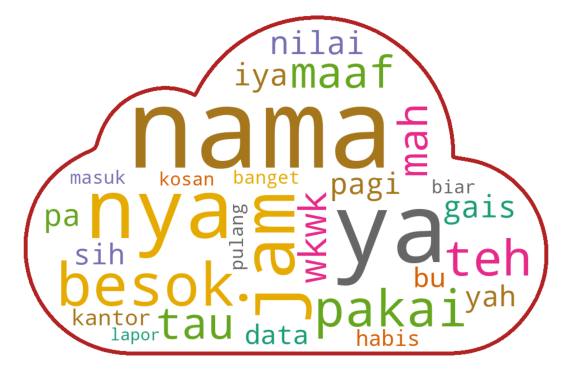

In [92]:
# WordCloud Label SMS Normal

sms_normal = data[data.label == 0]
normal_string = []

for t in sms_normal.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

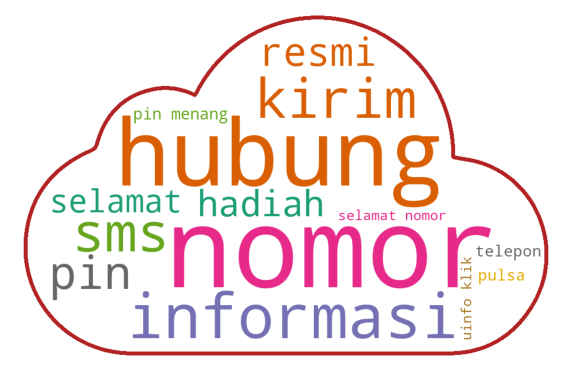

In [93]:
# WordCloud Label SMS Fraud / Penipuan

sms_fraud = data[data.label == 1]
fraud_string = []

for t in sms_fraud.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

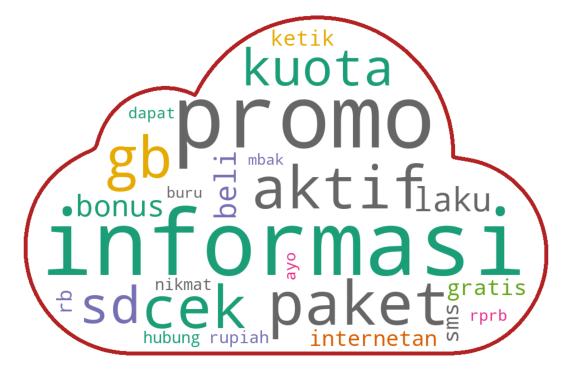

In [94]:
# WordCloud Label SMS Promo

sms_promo = data[data.label == 2]
promo_string = []

for t in sms_promo.clean_teks:
  promo_string.append(t)

promo_string = pd.Series(promo_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(promo_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Student Activity
Lakukan proses di atas menggunakan dataset review product https://drive.google.com/file/d/1qn5WXp-H95_FL_Rx5oqvfZaflYdHsnrF/view?usp=sharing

Tugas Anda:
- Tentukan langkah text pre-processing yang tepat untuk dataset di atas.
- Gunakan range `n_gram` yang berbeda. Amati apa perbedaannya.
- Menurut Anda, apakah `term` yang dihasilkan (`X_kbest_features`) pada feature selection sudah memiliki informasi yang relevan?

Setelah dikerjakan, buatlah resume berdasarkan pengalaman Anda dalam melakukan text pre-processing dan feature engineering.

Kumpulkan tugas Anda pada: https://s.id/tugas-nlp-ofa

Batas pengumpulan maksimal: Jumat, 1 April 2022